In [3]:
import os
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,concatenate,LSTM,SimpleRNN,Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
import traitlets
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

warnings.simplefilter("ignore")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=128):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    all_masks = []
    all_segments=[]
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size]
        encs = tokenizer.encode_batch(text_chunk)  
        all_ids.extend([enc.ids for enc in encs])
        all_masks.extend([enc.attention_mask for enc in encs])
        all_segments.extend([enc.type_ids for enc in encs])
    
    return np.array(all_ids),np.array(all_masks),np.array(all_segments)

In [5]:
def build_model_base(transformer,loss='binary_crossentropy',max_len=64):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")     
    masks = Input(shape=(max_len,), dtype=tf.int32, name="masks")
    segments = Input(shape=(max_len,), dtype=tf.int32, name="segments")
    sequence_output = transformer(input_word_ids,attention_mask=masks,token_type_ids=segments)[0]
    clf_output = sequence_output[:, 0, :]
    
    out = Dense(1, activation='sigmoid')(clf_output) 
    
    model = Model(inputs=[input_word_ids,masks,segments], outputs=out)
    model.compile(Adam(lr=2e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

In [6]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
#GCS_DS_PATH = KaggleDatasets().get_gcs_path('kaggle/input/') 

In [5]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [7]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_large_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_large_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [8]:
train = pd.read_csv('../input/quora-record-linkage/quora_train.csv',index_col=0,usecols=[1,2,3,4,5,6])
train = train.dropna()
test = pd.read_csv('../input/quora-record-linkage/quora_test.csv',index_col=0,usecols=[1,2,3,4,5,6])

In [9]:
seed = 7
np.random.seed(seed)
X = train.iloc[:,2:4]
Y = train.iloc[:,4]
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_test = test.iloc[:,2:4]
y_test = test.iloc[:,4]

In [10]:
x_train_ids,x_train_masks,x_train_segments=fast_encode(list(zip(X_train.question1.astype(str).tolist(),X_train.question2.astype(str).tolist())), fast_tokenizer, maxlen=128)
x_val_ids,x_val_masks,x_val_segments=fast_encode(list(zip(X_val.question1.astype(str).tolist(),X_val.question2.astype(str).tolist())), fast_tokenizer, maxlen=128)
x_test_ids, x_test_masks, x_test_segments=fast_encode(list(zip(X_test.question1.astype(str).tolist(),X_test.question2.astype(str).tolist())), fast_tokenizer, maxlen=128)

In [11]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(((x_train_ids,x_train_masks,x_train_segments),y_train))
    .repeat()
    .shuffle(2048)
    .batch(16)
    .prefetch(AUTO)
)

valid_dataset = ( 
    tf.data.Dataset 
    .from_tensor_slices(((x_val_ids,x_val_masks,x_val_segments),y_val)) 
    .batch(16) 
    .cache() 
    .prefetch(AUTO) 
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(((x_test_ids,x_test_masks,x_test_segments),y_test))
    .batch(16)
)

In [20]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    model = build_model_base(transformer_layer,max_len=128)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
masks (InputLayer)              [(None, 128)]        0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_3 (TFBertModel)   ((None, 128, 768), ( 109482240   input_word_ids[0][0]             
____________________________________________________________________________________________

In [12]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-large-uncased')
    model = build_model_base(transformer_layer,max_len=128)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
masks (InputLayer)              [(None, 128)]        0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 1024),  335141888   input_word_ids[0][0]             
_____________________________________________________________________________________________

In [13]:
train_history = model.fit(
    train_dataset,
    steps_per_epoch=150, 
    validation_data=valid_dataset,
    epochs=15
)

Epoch 1/15
150/150 [==============================] - 184s 1s/step - loss: 0.5122 - auc: 0.8017 - val_loss: 0.4713 - val_auc: 0.8803
Epoch 2/15
150/150 [==============================] - 162s 1s/step - loss: 0.4260 - auc: 0.8728 - val_loss: 0.3964 - val_auc: 0.9000
Epoch 3/15
150/150 [==============================] - 161s 1s/step - loss: 0.4098 - auc: 0.8811 - val_loss: 0.3748 - val_auc: 0.9112
Epoch 4/15
150/150 [==============================] - 164s 1s/step - loss: 0.4294 - auc: 0.8687 - val_loss: 0.4265 - val_auc: 0.8998
Epoch 5/15
150/150 [==============================] - 162s 1s/step - loss: 0.3786 - auc: 0.8970 - val_loss: 0.3509 - val_auc: 0.9176
Epoch 6/15
150/150 [==============================] - 166s 1s/step - loss: 0.3732 - auc: 0.9054 - val_loss: 0.3485 - val_auc: 0.9191
Epoch 7/15
150/150 [==============================] - 163s 1s/step - loss: 0.3791 - auc: 0.9005 - val_loss: 0.3452 - val_auc: 0.9199
Epoch 8/15
150/150 [==============================] - 163s 1s/step - 

In [15]:
train_history = model.fit(
    train_dataset,
    steps_per_epoch=150, 
    validation_data=valid_dataset,
    epochs=5
)

Epoch 1/5
150/150 [==============================] - 161s 1s/step - loss: 0.2977 - auc: 0.9385 - val_loss: 0.3469 - val_auc: 0.9325
Epoch 2/5
150/150 [==============================] - 163s 1s/step - loss: 0.2567 - auc: 0.9548 - val_loss: 0.3373 - val_auc: 0.9325
Epoch 3/5
150/150 [==============================] - 165s 1s/step - loss: 0.2338 - auc: 0.9622 - val_loss: 0.3659 - val_auc: 0.9273
Epoch 4/5
150/150 [==============================] - 164s 1s/step - loss: 0.2619 - auc: 0.9518 - val_loss: 0.3589 - val_auc: 0.9310
Epoch 5/5
150/150 [==============================] - 163s 1s/step - loss: 0.2584 - auc: 0.9541 - val_loss: 0.3093 - val_auc: 0.9360


In [16]:
model.save_weights("bert_large_model.h5")

In [18]:
model.load_weights("bert_large_model.h5")

In [19]:
model.evaluate(test_dataset)

5055/5055 [==============================] - 179s 35ms/step - loss: 0.3085 - auc: 0.9360


[0.3084823191165924, 0.936032772064209]

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Precision-Recall curve: AP=0.88')

<Figure size 432x288 with 0 Axes>

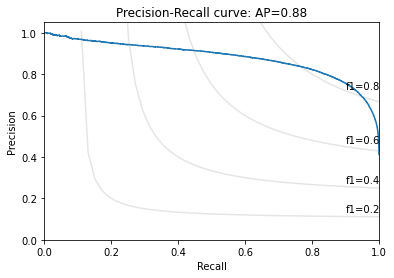

In [21]:
y_score=model.predict(test_dataset)
precision, recall, f1=precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score,average="micro")

plt.clf()
plt.figure()
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
plt.step(recall,precision,where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Precision-Recall curve: AP={0:0.2f}'
    .format(average_precision))